# Lab5. SVD and weighted SVD on MovieLens.

In [65]:
import os

import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

### 1) MovieLens Dataset.

#### a) This data set consists of:
   - 100,000 ratings (1-5) from 943 users on 1682 movies.
   - Each user has rated at least 20 movies.

#### b) It is preferable to begin with this dataset, because its size is applicable for the research purposes and was preprocessed by the authors.

#### c) Data loading.

In [32]:
NUM_RATINGS = int(1e5)
DATA_SHAPE = (943, 1682)
DATA_DIR = os.path.join(".", "data", "movielens", "ml-100k")

In [24]:
ratings_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", header=None, names=("User ID", "Item ID", "Rating", "Timestamp"))
ratings_df.head(10)

,User ID,Item ID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [25]:
ratings_df.groupby("User ID")["Item ID"].count().describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: Item ID, dtype: float64

In [27]:
values = ratings_df.values
values[:, 0:2] -= 1
ratings_df.head()

,User ID,Item ID,Rating,Timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


#### d) The difference between table df and rating matrix M is that table df contains raw data of records and has shape (100k x #features), while matrix M will be sparse rating matrix of shape (#users x #items) with rating or miss in each cell.

### Data preprocessing.

#### a) Obtain a sparse rating matrix M.

In [30]:
M = csr_matrix((ratings_df["Rating"], (ratings_df["User ID"], ratings_df["Item ID"])), dtype=np.float64, shape=DATA_SHAPE)
M

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 100000 stored elements in Compressed Sparse Row format>

#### b) In a sparse matrix, missing data is typically represented by a special value, such as zero or NaN (not a number).

#### c) Perform train-test split.

In [53]:
train_fraction = 0.9
train_size = int(train_fraction * NUM_RATINGS)

indices = np.random.permutation(range(NUM_RATINGS))
indices_train = indices[0:train_size]
indices_test = indices[train_size:NUM_RATINGS]

M_train = csr_matrix((ratings_df["Rating"][indices_train], (ratings_df["User ID"][indices_train], ratings_df["Item ID"][indices_train])),
                     dtype=float, shape=DATA_SHAPE)
M_test = csr_matrix((ratings_df["Rating"][indices_test], (ratings_df["User ID"][indices_test], ratings_df["Item ID"][indices_test])),
                    dtype=float, shape=DATA_SHAPE)

In [54]:
print(M_train.__repr__())
print(M_test.__repr__())

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 90000 stored elements in Compressed Sparse Row format>
<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 10000 stored elements in Compressed Sparse Row format>


#### d) Compute global mean rating.

In [60]:
global_mean_rating = np.sum(M_train) / np.sum(M_train > 0.5)
print(f"Global mean rating: {global_mean_rating:.3f}")

Global mean rating: 3.530


#### e) Compute test MSE if prediction is made using global mean rating.

In [61]:
mask_train = M_train > 0.5
mask_test = M_test > 0.5

diff = np.array(M_test[mask_test] - global_mean_rating)
mse = np.mean(diff ** 2)
rmse = mse ** (1 / 2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 1.2701900334567902
RMSE: 1.1270270775171243


### Recommending using SVD.

#### a) Compute the 20 First factors of the SVD of the centered training data.

In [202]:
M_train_centered = M_train.copy()
M_train_centered[mask_train] = M_train[mask_train] - global_mean_rating
M_test_centered = M_test.copy()
M_test_centered[mask_test] = M_test[mask_test] - global_mean_rating

In [203]:
num_factors = 20

U, D, Vt = svds(M_train_centered, k=num_factors)

U = U[:, ::-1]
D = D[::-1]
Vt = Vt[::-1, :]

In [204]:
print(U.shape, D.shape, Vt.shape)

(943, 20) (20,) (20, 1682)


#### b) Predict missing test values using different number of components and plot it.

In [205]:
def svd_mse(_U, _D, _Vt, k):
    _M_pred = _U[:, 0:k] @ np.diag(_D[0:k]) @ _Vt[0:k, :]
    # _M_pred = _U[:, 0:k] @ _Vt[0:k, :]

    _M_err = M_test_centered - mask_test.multiply(_M_pred)

    _mse = np.sum(_M_err.power(2)) / np.sum(mask_test)

    return _mse

In [206]:
errors = list()

for i in range(1, num_factors + 1):
    errors.append(svd_mse(U, D, Vt, i))

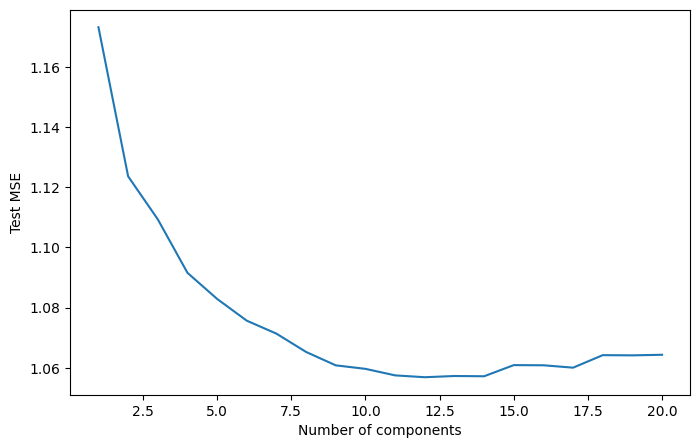

In [207]:
plt.figure(figsize=(8, 5))
plt.xlabel("Number of components")
plt.ylabel("Test MSE")
plt.plot(range(1, num_factors + 1), errors)
plt.show()

### Recommending using the weighted SVD.

#### a) Alternating least square.

In [208]:
def mse(_U, _D, _Vt):
    # _M_pred = _U @ np.diag(_D) @ _Vt
    _M_pred = _U @ _Vt

    _M_err = M_test_centered - mask_test.multiply(_M_pred)

    _mse = np.sum(_M_err.power(2)) / np.sum(mask_test)

    return _mse

In [209]:
_lambda = 2
n_iter = 15

U_star = U.copy()
Vt_star = Vt.copy()

errors = list()

for iteration in range(n_iter):
    print(f"Iteration: {iteration}")

    for i in range(len(U)):
        Di = np.diag(mask_train[i].toarray().flatten())
        A = np.linalg.pinv(Vt_star @ Di @ Vt_star.T + _lambda * np.identity(num_factors))
        Ri = M_train_centered[i].T
        B = Vt_star @ Di @ Ri
        U_star[i] = (A @ B).flatten()

    for j in range(Vt.shape[1]):
        Dj = np.diag(mask_train[:, j].toarray().flatten())
        Rj = M_train_centered[:, j]
        A = np.linalg.pinv(U_star.T @ Dj @ U_star + _lambda * np.identity(num_factors))
        B = U_star.T @ Dj @ Rj
        Vt_star[:, j] = (A @ B).flatten()

    error = mse(U_star, D, Vt_star)
    errors.append(error)
    print(f"Test MSE: {error}")

Iteration: 0
Test MSE: 1.2779901135296812
Iteration: 1
Test MSE: 1.2270220613283616
Iteration: 2
Test MSE: 1.2018540367464845
Iteration: 3
Test MSE: 1.1867357733211237
Iteration: 4
Test MSE: 1.1775123027738266
Iteration: 5
Test MSE: 1.1714271277962103
Iteration: 6
Test MSE: 1.1673957949782041
Iteration: 7
Test MSE: 1.164947434358297
Iteration: 8
Test MSE: 1.16374397536411
Iteration: 9
Test MSE: 1.1634758828441412
Iteration: 10
Test MSE: 1.1638681644199382
Iteration: 11
Test MSE: 1.1646873495277483
Iteration: 12
Test MSE: 1.1657439525368212
Iteration: 13
Test MSE: 1.1668963076446741
Iteration: 14
Test MSE: 1.1680514931393229


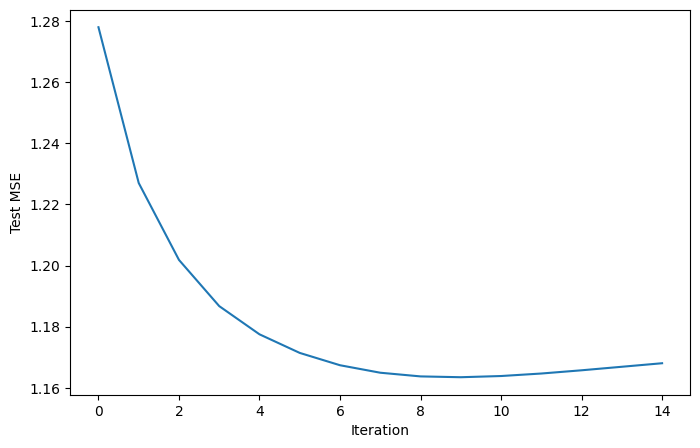

In [210]:
plt.figure(figsize=(8, 5))
plt.xlabel("Iteration")
plt.ylabel("Test MSE")
plt.plot(range(n_iter), errors)
plt.show()